In [1]:
# from google.colab import drive

# drive.mount('/gdrive')

# %cd /gdrive/My Drive/[2024-2025] AN2DL Homework 1

#directory of my folder in google drive

In [2]:
seed = 85 # random variable to make the code reproducible







# Import necessary libraries



import os







# Set environment variables before importing modules



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



os.environ['PYTHONHASHSEED'] = str(seed)



os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'







# Suppress warnings



import warnings



warnings.simplefilter(action='ignore', category=FutureWarning)



warnings.simplefilter(action='ignore', category=Warning)







# Import necessary modules



import numpy as np



import hashlib



import logging



import random







# Set seeds for random number generators in NumPy and Python



np.random.seed(seed)



random.seed(seed)







# Import TensorFlow and Keras



import tensorflow as tf



from tensorflow import keras as tfk



from tensorflow.keras import layers as tfkl







# Set seed for TensorFlow



tf.random.set_seed(seed)



tf.compat.v1.set_random_seed(seed)







# Reduce TensorFlow verbosity



tf.autograph.set_verbosity(0)



tf.get_logger().setLevel(logging.ERROR)



tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)







# Print TensorFlow version



print(tf.__version__)







# Import other libraries



import matplotlib.pyplot as plt



import pandas as pd



from sklearn.model_selection import train_test_split



from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score



from sklearn.utils.class_weight import compute_class_weight



import seaborn as sns



from PIL import Image



import matplotlib.gridspec as gridspec







# Configure plot display settings



sns.set(font_scale=1.4)



sns.set_style('white')



plt.rc('font', size=14)



%matplotlib inline

2.16.1


In [3]:
data = np.load('/kaggle/input/dataset-clean/training_set_cleaned.npz') # load the blood cells dataset into a variable called 'data'



print(data.files)



# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [4]:
# Define a mapping of labels to their corresponding digit names



classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes



# Save unique labels



unique_labels = list(classes.values())

In [5]:
# splitting between images and labels



X = data['images']



y = data['labels']



print(X.shape)



print(y.shape)

(11353, 96, 96, 3)
(11353, 1)


In [6]:
print(X.min(), X.max())

0 255


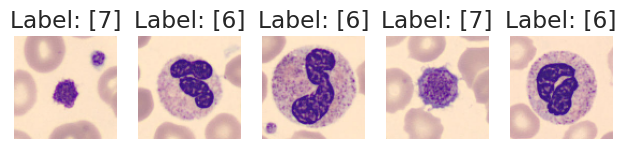

In [7]:
for i in range(5):



    plt.subplot(1, 5, i + 1)  # Arrange plots in a single row



    plt.imshow(X[i])  # Display image, adjust cmap if images are in grayscale



    plt.title(f"Label: {y[i]}")



    plt.axis('off')  # Remove axes for better visibility







plt.tight_layout()



plt.show()

In [8]:
# keeping 80% for the training set and 20% for the validation



X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)







print("Train:", X_train.shape, y_train.shape)



print("Validation:", X_val.shape, y_val.shape)

Train: (9082, 96, 96, 3) (9082, 1)
Validation: (2271, 96, 96, 3) (2271, 1)


In [9]:
# compute_class_weight



class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())



class_weight_dict = dict(zip(np.unique(y_train), class_weights))



class_weight_dict

{0: 1.733206106870229,
 1: 0.6741389548693587,
 2: 1.3827649208282582,
 3: 0.8214544138929089,
 4: 1.6918777943368106,
 5: 1.5403663500678426,
 6: 0.6227372462973121,
 7: 0.8672650878533231}

In [10]:
# Convert labels to categorical format using one-hot encoding



y_train = y_train.flatten()



y_val = y_val.flatten()



y_train

array([0, 6, 5, ..., 7, 1, 6], dtype=uint8)

In [11]:
input_shape = (96,96,3) # input shape our dataset



output_shape = len(np.unique(y_train)) # output shape: 8 classes



print("Input Shape:", input_shape)



print("Output Shape:", output_shape)







# it makes sense because the input shape is the dimension of the image and 3 channels



# and the output is 8 as the number of the possible classes

Input Shape: (96, 96, 3)
Output Shape: 8


In [12]:
epochs = 100 # epochs



batch_size = 64 # batch



learning_rate = 1e-4 # step size for updating the model's weights

In [13]:
augmentations = tf.keras.Sequential([

    tf.keras.layers.RandomRotation(0.3),  # Rotate by 20%

    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip both ways

    tf.keras.layers.RandomZoom(0.1),  # Zoom in/out

    #tf.keras.layers.RandomTranslation(0.2, 0.2),  # Shift horizontally/vertically

    tf.keras.layers.RandomBrightness(0.2, value_range=(0,255)),  # Brightness adjustment

    #tf.keras.layers.RandomContrast(0.2),  # Contrast adjustment

    tf.keras.layers.GaussianNoise(0.2)

])



X_train_aug = augmentations(X_train)


In [14]:
from tensorflow.keras.applications import InceptionV3



from tensorflow.keras.models import Model







# Initialise ResNet50 model with pretrained weights, for transfer learning



InceptionV3 = tfk.applications.InceptionV3(



    include_top=False,



    weights="imagenet",



    input_shape=input_shape

)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
from tensorflow.keras.applications import InceptionV3



from tensorflow.keras.models import Model



from tensorflow.keras.layers import Dropout, Dense



from tensorflow.keras.applications.inception_v3 import preprocess_input



# RETE PRE ADDESTRATA



model = InceptionV3(



    input_shape=(96,96,3),



    include_top=False, # in pratica sto togliendo il dense layer per risolvere un mio task enon la classificazione



    weights='imagenet',



    pooling = 'avg'



)





# Freeze all layers in InceptionV3 to use it solely as a feature extractor



model.trainable = False







# input layer



inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')







#x = tf.keras.layers.Resizing(224, 224)(inputs)

#x = augmentations(inputs)



x = preprocess_input(inputs)



# Uso lo strato della rete



x = model(x)





# Strato denso finale per la classificazione (output)

x = tfkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02),name="dense_1")(x)



x = tfkl.Dropout(0.5, name='dropout1')(x)



x = tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02),name="dense_2")(x)



x = tfkl.Dropout(0.5, name='dropout2')(x)







outputs = tfkl.Dense(8, activation='softmax', name='denseo')(x)







# Create a Model connecting input and output



model = tfk.Model(inputs=inputs, outputs=outputs, name='model')







# Compile the model with Categorical Cross-Entropy loss and Adam optimizer



model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(),



              optimizer=tfk.optimizers.Lion(learning_rate = learning_rate),



              metrics=['accuracy'])



# Display a summary of the model architecture

#model.summary(expand_nested=True)

In [16]:
# Train the model



history_stage1 = model.fit(



    x=X_train_aug,



    y=y_train,



    batch_size=batch_size,



    epochs=30,



    class_weight=class_weight_dict,



    validation_data=(X_val, y_val),



    callbacks=[

        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),

    ]



).history







# Calculate and print the best validation accuracy achieved



final_val_accuracy = round(max(history_stage1['val_accuracy']) * 100, 2)



print(f'Final validation accuracy: {final_val_accuracy}%')







# Save the trained model to a file, including final accuracy in the filename



#model.save('TL_ResNet50.keras')

Epoch 1/30


I0000 00:00:1732306862.683776     103 service.cc:145] XLA service 0x59b2c8f945a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732306862.683839     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732306862.683846     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/142 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.0845 - loss: 27.4994

I0000 00:00:1732306872.435483     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - accuracy: 0.3171 - loss: 22.8105 - val_accuracy: 0.7323 - val_loss: 13.1423
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6614 - loss: 11.1002 - val_accuracy: 0.7869 - val_loss: 5.6306
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7433 - loss: 4.7671 - val_accuracy: 0.8071 - val_loss: 2.5491
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7767 - loss: 2.3482 - val_accuracy: 0.8102 - val_loss: 1.5378
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8007 - loss: 1.4384 - val_accuracy: 0.8208 - val_loss: 1.0538
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8014 - loss: 1.0721 - val_accuracy: 0.8181 - val_loss: 0.9051
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8028 - loss: 0.9678 - val_accuracy: 0.8199 - val_loss: 0.8844
Epoch 8/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8053 - loss: 0.9337 - val_accuracy: 

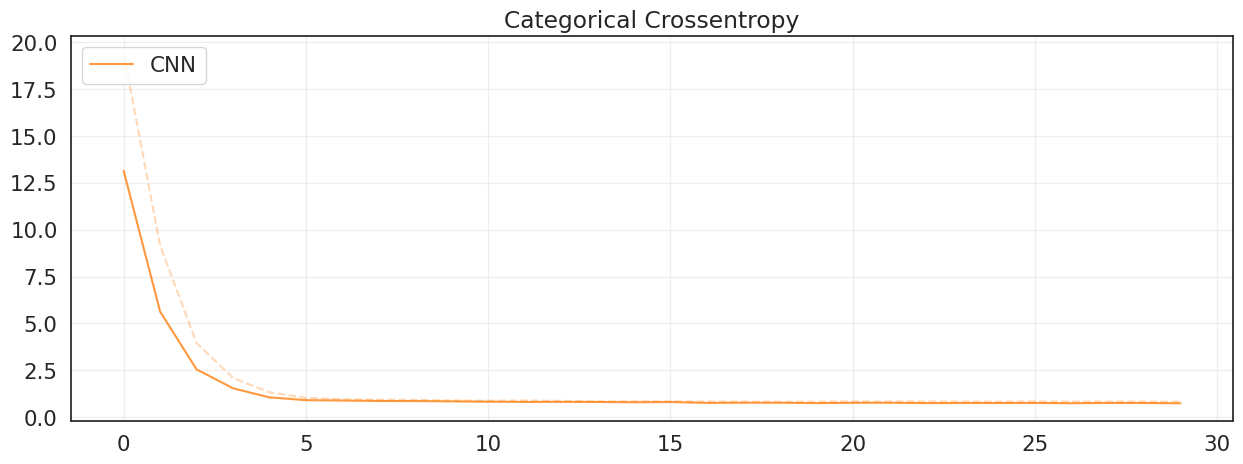

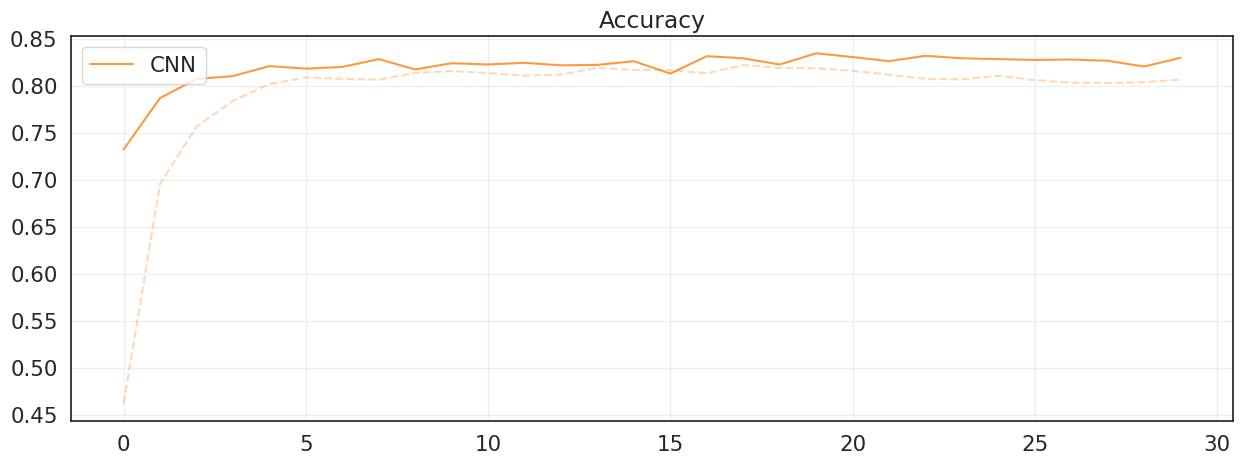

In [17]:
# Plot the training



plt.figure(figsize=(15,5))



plt.plot(history_stage1['loss'], alpha=.3, color='#ff7f0e', linestyle='--')



plt.plot(history_stage1['val_loss'], label='CNN', alpha=.8, color='#ff7f0e')



plt.legend(loc='upper left')



plt.title('Categorical Crossentropy')



plt.grid(alpha=.3)







plt.figure(figsize=(15,5))



plt.plot(history_stage1['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')



plt.plot(history_stage1['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')



plt.legend(loc='upper left')



plt.title('Accuracy')



plt.grid(alpha=.3)

In [22]:
y_prob = model.predict(X_val)

y_pred = y_prob.argmax(axis=1)

y_pred

71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step


array([4, 1, 6, ..., 3, 6, 1])

Accuracy: 0.8296
F1 Score: 0.8302

Classification Report:
               precision    recall  f1-score   support

           0     0.6439    0.8148    0.7193       162
           1     0.8904    0.9227    0.9063       414
           2     0.8536    0.8908    0.8718       229
           3     0.6768    0.6941    0.6853       353
           4     0.7793    0.6890    0.7314       164
           5     0.7117    0.6554    0.6824       177
           6     0.9459    0.8425    0.8912       457
           7     0.9564    0.9746    0.9654       315

    accuracy                         0.8296      2271
   macro avg     0.8072    0.8105    0.8066      2271
weighted avg     0.8343    0.8296    0.8302      2271



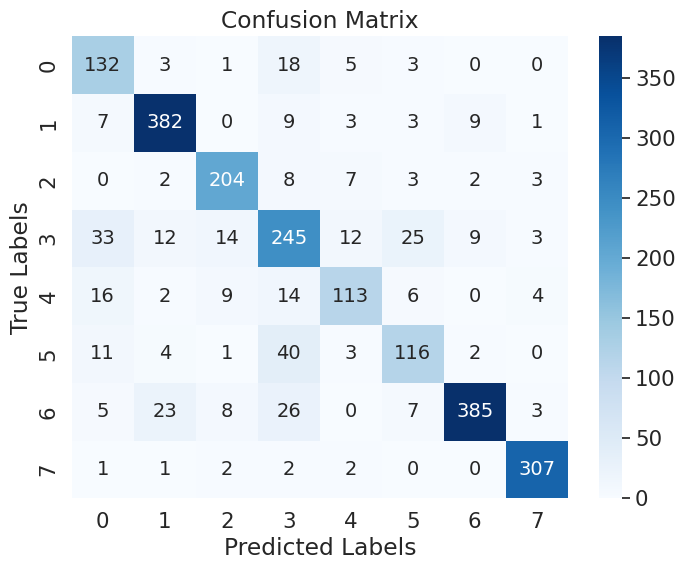

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score







# Calculate metrics



accuracy = accuracy_score(y_val, y_pred)



f1 = f1_score(y_val, y_pred, average='weighted')







# Print the results



print(f"Accuracy: {accuracy:.4f}")



print(f"F1 Score: {f1:.4f}")







# Detailed per-class metrics



print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))







# Compute confusion matrix



cm = confusion_matrix(y_val, y_pred)







# Create a heatmap for the confusion matrix



plt.figure(figsize=(8, 6))



sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))



plt.title('Confusion Matrix')



plt.xlabel('Predicted Labels')



plt.ylabel('True Labels')







# Display the plot



plt.show()

In [20]:
#from tensorflow.keras.models import Model



# Re-load the model after transfer learning



#ft_model = tfk.models.load_model('TL_ResNet50.keras')



# Unfreezing the last 10 layers of the base model (two blocks)



for layer in model.layers[-10:]:



    layer.trainable = True





# Step 2: Recompile the model with a lower learning rate



model.compile(



    loss=tfk.losses.SparseCategoricalCrossentropy(),



    optimizer=tfk.optimizers.Lion(learning_rate=1e-5),  # Lower learning rate for fine-tuning



    metrics=['accuracy']



)



# Display a summary of the model architecture



#ft_model.summary(expand_nested=True)

In [21]:
# Train the model



history_stage2 = model.fit(



    x=X_train_aug,



    y=y_train,



    batch_size=batch_size,



    epochs=epochs-30,



    class_weight=class_weight_dict,



    validation_data=(X_val, y_val),



    callbacks=[

        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),

        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    ]



).history

# Calculate and print the best validation accuracy achieved



final_val_accuracy = round(max(history_stage2['val_accuracy']) * 100, 2)



print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/70


KeyboardInterrupt: 

In [ ]:
# Plot the training



plt.figure(figsize=(15,5))



plt.plot(history_stage2['loss'], label='Training Loss',alpha=.3, color='#ff7f0e', linestyle='--')



plt.plot(history_stage2['val_loss'], label='Validation Loss', alpha=.8, color='#ff7f0e')



plt.legend(loc='upper left')



plt.title('Categorical Crossentropy')



plt.grid(alpha=.3)







plt.figure(figsize=(15,5))



plt.plot(history_stage2['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')



plt.plot(history_stage2['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')



plt.legend(loc='upper left')



plt.title('Accuracy')



plt.grid(alpha=.3)

In [ ]:
# Predict probabilities for the test set



y_prob= model.predict(X_val)

y_pred = y_prob.argmax(axis=1)

In [ ]:
# Save model

model.save('weights.keras')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score







# Calculate metrics



accuracy = accuracy_score(y_val, y_pred)



f1 = f1_score(y_val, y_pred, average='weighted')







# Print the results



print(f"Accuracy: {accuracy:.4f}")



print(f"F1 Score: {f1:.4f}")







# Detailed per-class metrics



print("\nClassification Report:\n", classification_report(y_val, y_pred, digits = 4))







# Compute confusion matrix



cm = confusion_matrix(y_val, y_pred)







# Create a heatmap for the confusion matrix



plt.figure(figsize=(8, 6))



sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))



plt.title('Confusion Matrix')



plt.xlabel('Predicted Labels')



plt.ylabel('True Labels')







# Display the plot



plt.show()

In [ ]:
%%writefile model.py



import numpy as np







import tensorflow as tf



from tensorflow import keras as tfk



from tensorflow.keras import layers as tfkl











class Model:



    def __init__(self):



        """



        Initialize the internal state of the model. Note that the __init__



        method cannot accept any arguments.







        The following is an example loading the weights of a pre-trained



        model.



        """



        self.neural_network = tfk.models.load_model('weights.keras')







    def predict(self, X):



        """



        Predict the labels corresponding to the input X. Note that X is a numpy



        array of shape (n_samples, 96, 96, 3) and the output should be a numpy



        array of shape (n_samples,). Therefore, outputs must no be one-hot



        encoded.







        The following is an example of a prediction from the pre-trained model



        loaded in the __init__ method.



        """



        preds = self.neural_network.predict(X)



        if len(preds.shape) == 2:



            preds = np.argmax(preds, axis=1)



        return preds

In [ ]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'



# Add files to the zip command if needed

!zip {filename} model.py weights.keras



from google.colab import files

files.download(filename)